In [2]:
import numpy as np
import pyvista as pv
pv.Report(gpu=True)
from scipy.interpolate import LinearNDInterpolator
import sys
sys.path.append('../../')

import pydem.SyntheticTerrain as st
import pydem.Geometry as gm
import pydem.Graphic as pyvis
import pydem.HazardDetection as hd
import pydem.util as util
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

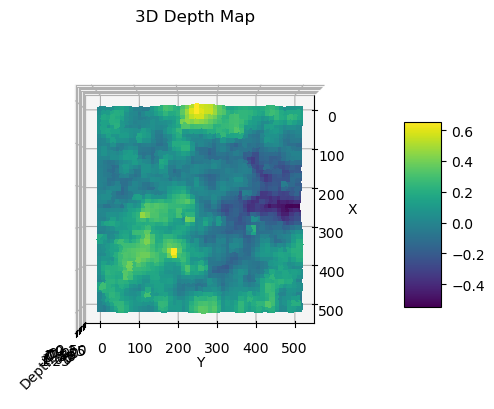

In [14]:
nh, nw = 512, 512
res = 0.1
dem = st.rocky_terrain(shape=(nh, nw), res=res, k=0.15, dmax=1.5, dmin=0.1)
terrain = st.dsa(dem, hmax=0.7, rng=RandomState(1223))
from numpy.random import RandomState

# smooth the terrain
from scipy.ndimage import gaussian_filter
dem += gaussian_filter(terrain, sigma=2)

depth_data = dem.copy()
# Create x and y coordinates (assuming depth data is a 2D array)
x, y = np.mgrid[0:depth_data.shape[0], 0:depth_data.shape[1]]

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x, y, depth_data, cmap='viridis', linewidth=0, antialiased=False)

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth')
plt.title('3D Depth Map')

# Add a colorbar
fig.colorbar(surf, shrink=0.5, aspect=5)

# CHange the viewing angle to 90 degrees
ax.view_init(90, 0)

# Show the plot
plt.show()

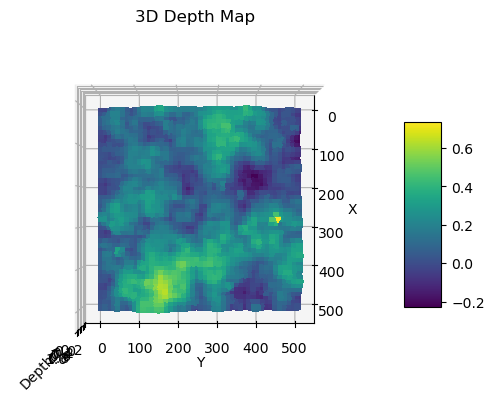

In [15]:
depth_data = dem.copy()
# Create x and y coordinates (assuming depth data is a 2D array)
x, y = np.mgrid[0:depth_data.shape[0], 0:depth_data.shape[1]]

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x, y, depth_data, cmap='viridis', linewidth=0, antialiased=False)

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth')
plt.title('3D Depth Map')

# Add a colorbar
fig.colorbar(surf, shrink=0.5, aspect=5)

# CHange the viewing angle to 90 degrees
ax.view_init(90, 0)

# Show the plot
plt.show()

In [16]:
dl = 3.0
dp = 0.3
rmpp = 0.1

fpmap, site_slope, site_rghns, pix_rghns, site_safe, indef = hd.dhd(
        dem, 
        rmpp=rmpp, 
        negative_rghns_unsafe=False,
        lander_type='square', 
        dl=dl, 
        dp=dp,
        scrit=10*np.pi/180,
        rcrit=0.3)

In [17]:
# Create mesh from DEM
h, w = dem.shape
x = np.linspace(0, nh * res, h)
y = np.linspace(0, nw * res, w)
xc, yc = np.mean(x), np.mean(y)
x -= xc
y -= yc
yy, xx = np.meshgrid(y, x)
mesh = pv.StructuredGrid(xx, yy, dem)

# Add scalar attributes to mesh
mesh.point_data.set_array(fpmap.flatten('F'), 'fpmap')
mesh.point_data.set_array(site_slope.flatten('F'), 'site_slope')
mesh.point_data.set_array(site_rghns.flatten('F'), 'site_rghns')
mesh.point_data.set_array(pix_rghns.flatten('F'), 'pix_rghns')
mesh.point_data.set_array(site_safe.flatten('F'), 'site_safe')

In [18]:
mesh.set_active_scalars('site_safe')
# mesh.plot()

(<FieldAssociation.POINT: 0>,
 pyvista_ndarray([0, 0, 0, ..., 0, 0, 0], dtype=int32))

### GT Safety

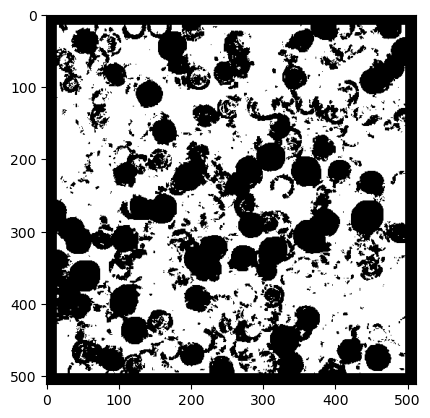

In [19]:
import matplotlib.pyplot as plt
plt.imshow(site_safe, cmap='gray')

In [20]:
# prepare rays in camera frame

def rays_in_c(dsize: int=1024, fov_width: float=100.0, alt: float=500.0):
    """
    Generate rays in camera frame

    Args:
        fov_width (float, optional): Field of view width. Defaults to 100.0.
        alt (float, optional): Altitude. Defaults to 500.0.
        dsize (int, optional): Resolution parameter. Number of data points within 100 m at altitude of 500 m. Defaults to 1024.
    """
    # rays in camera frame
    n = dsize ** 2
    rays = np.zeros((n, 3))
    x = np.linspace(-fov_width/2, fov_width/2, dsize)
    y = np.linspace(-fov_width/2, fov_width/2, dsize)
    yy, xx = np.meshgrid(y, x)
    rays[:, 0] = xx.flatten()
    rays[:, 1] = yy.flatten()
    rays[:, 2] = alt

    return rays

GREEN = np.array([73, 235, 52])
BLUE = np.array([52, 79, 235])
RED = np.array([235, 64, 52])
PINK = np.array([255, 0, 127])
YELLOW = np.array([235, 217, 52])
NAVY = np.array([0, 0, 102])

def pred2img(label, pred):
    h, w = label.shape
    img = np.zeros((h, w, 3), dtype=np.uint8)
    img[label == -1] = NAVY  # invalid
    img[(label == 1) * (pred == 1)] = GREEN  # true safe
    img[(label == 0) * (pred != 1)] = YELLOW  # true unsafe
    img[(label == 1) * (pred != 1)] = BLUE  # false unsafe
    img[(label == 0) * (pred == 1)] = RED  # false safe
    return img

def sim_hd(alt, theta, xx, yy, sfmap, dem):
    # target region
    x_min, x_max = -10, 10
    y_min, y_max = -10, 10
    mask = (xx > x_min) & (xx < x_max) & (yy > y_min) & (yy < y_max)
    xx_masked = xx[mask]
    yy_masked = yy[mask]
    shape = (int((x_max - x_min) / res), int((y_max - y_min) / res))
    xx_masked = xx_masked.reshape(shape)
    yy_masked = yy_masked.reshape(shape)

    # sim lidar scan
    rays_c = rays_in_c(256, 100.0, 500.0)

    e1_c = np.array([-1.0, 0.0, 0.0])
    e3_c = np.array([0.0, -np.sin(theta), -np.cos(theta)])
    e2_c = np.cross(e3_c, e1_c)
    R_C2W = np.vstack((e1_c, e2_c, e3_c)).T

    rays_w = R_C2W @ rays_c.T
    rays_w = rays_w.T

    n = rays_w.shape[0]
    src = np.array([0.0, alt * np.sin(theta), alt * np.cos(theta)] * n).reshape(n, 3)

    pcd, idr, _ = dtm.ray.intersects_location(src, rays_w, multiple_hits=False)

    # hazard detection
    interp = LinearNDInterpolator(pcd[:, :2], pcd[:, 2], fill_value=0.0)
    dem_coarse = interp(xx, yy)

    dl = 3.0
    dp = 0.3
    rmpp = 0.1

    fpmap, site_slope, site_rghns, pix_rghns, site_safe, indef = hd.dhd(
        dem_coarse, 
        rmpp=rmpp, 
        negative_rghns_unsafe=False,
        lander_type='square', 
        dl=dl, 
        dp=dp,
        scrit=10*np.pi/180,
        rcrit=0.3)
    is_safe_coarse = site_safe
    
    # masking
    safety_target = sfmap[mask]
    safety_coarse_target = is_safe_coarse[mask]

    shape = (int((x_max - x_min) / res), int((y_max - y_min) / res))
    safety_target = safety_target.reshape(shape)
    safety_coarse_target = safety_coarse_target.reshape(shape)

    pred_img = pred2img(safety_target, safety_coarse_target)

    dem_coarse_target = dem_coarse[mask].reshape(shape)
    dem_target = dem[mask].reshape(shape)

    pcd_mask = (pcd[:, 0] > x_min) & (pcd[:, 0] < x_max) & (pcd[:, 1] > y_min) & (pcd[:, 1] < y_max)
    pcd_target = pcd[pcd_mask]

    return pred_img, safety_target, safety_coarse_target, dem_target, dem_coarse_target, pcd_target, xx_masked, yy_masked


def vis_sim(alt, theta, xx, yy, sfmap, dem):
    pred_img, safety_target, safety_coarse_target, dem_target, dem_coarse_target, pcd_target, xx_masked, yy_masked = sim_hd(alt, theta, xx, yy, sfmap, dem)
    miss_rate = np.sum(safety_target != safety_coarse_target) / safety_target.size

    # reverse the second axis
    pred_img_flipped = pred_img[::-1, :, :]
    texture = pv.numpy_to_texture(pred_img_flipped)
    local = pv.StructuredGrid(xx_masked, yy_masked, dem_target)

    # Create texture coordinates
    coords = np.zeros((local.points.shape[0], 2))
    coords[:, 0] = local.points[:, 0] / local.points[:, 0].max()
    coords[:, 1] = local.points[:, 1] / local.points[:, 1].max()

    # Add texture coordinates to the grid
    local.point_data['Texture Coordinates'] = coords

    # Map the texture to the grid
    local.texture_map_to_plane(inplace=True)

    # Plot the grid with the texture
    plotter = pv.Plotter()
    plotter.add_mesh(local, texture=texture)

    # Add text for the current altitude and the rate of miss detection
    plotter.add_text("Altitude: {:.0f}m".format(alt), position='upper_left', font_size=10)
    plotter.add_text("Miss Detection Rate: {:.0f}%".format(miss_rate * 100), position='upper_right', font_size=10)

    plotter.show(auto_close=False)
    plotter.screenshot('sim_hd_alt_{:.0f}.png'.format(alt))
    plotter.close()


    

In [21]:
alt_list = [700.0, 500.0, 300.0, 100.0]
alt_list = np.linspace(800.0, 300.0, 10)

for alt in alt_list:
    plotter = vis_sim(alt, 0.0, xx, yy, site_safe, dem)

: 

In [249]:
import imageio
import glob

# Get a list of all PNG files
file_list = sorted(glob.glob('sim_hd_alt_*.png'))

# sort by altitude; descending order
file_list = sorted(file_list, key=lambda x: int(x.split('_')[-1].split('.')[0]), reverse=True)

# Read each image file and append it to a list
images = [imageio.imread(file) for file in file_list]

# Repeat first and last frames to make the GIF slower and easier to see
images = [images[0]] + images + [images[-1]]*2

# Save the images as a GIF
imageio.mimsave('output.gif', images, duration=0.5)

C:\Users\ktomita3\AppData\Local\Temp\ipykernel_13744\2893343811.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(file) for file in file_list]


In [202]:
sfmap = site_safe
pred_img, safety_target, safety_coarse_target, dem_coarse_target, pcd_target, xx_masked, yy_masked = sim_hd(300.0, 10.0, xx, yy, sfmap)

c:\Users\ktomita3\.conda\envs\pydem\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


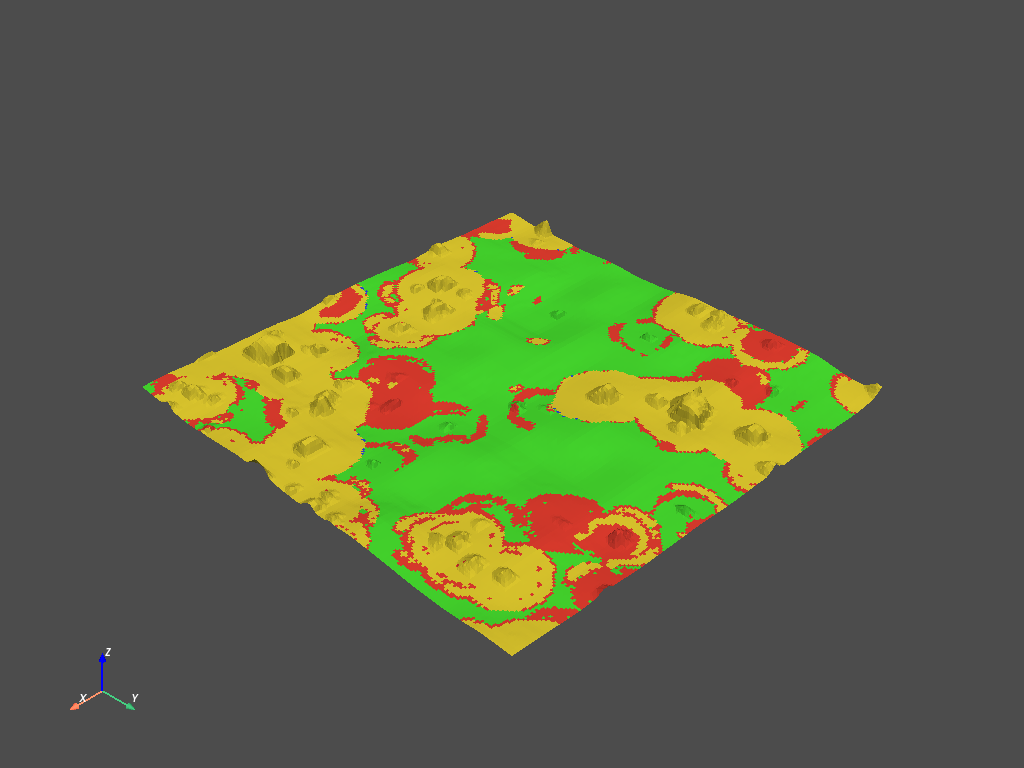

In [203]:
# Your existing code to create a structured grid
#pred_img_flipped = np.transpose(pred_img, (1, 0, 2))
# reverse the second axis
pred_img_flipped = pred_img[::-1, :, :]
texture = pv.numpy_to_texture(pred_img_flipped)
local = pv.StructuredGrid(xx_masked, yy_masked, dem_coarse_target)

# Create texture coordinates
coords = np.zeros((local.points.shape[0], 2))
coords[:, 0] = local.points[:, 0] / local.points[:, 0].max()
coords[:, 1] = local.points[:, 1] / local.points[:, 1].max()

# Add texture coordinates to the grid
local.point_data['Texture Coordinates'] = coords

# Map the texture to the grid
local.texture_map_to_plane(inplace=True)

# Plot the grid with the texture
local.plot(texture=texture)

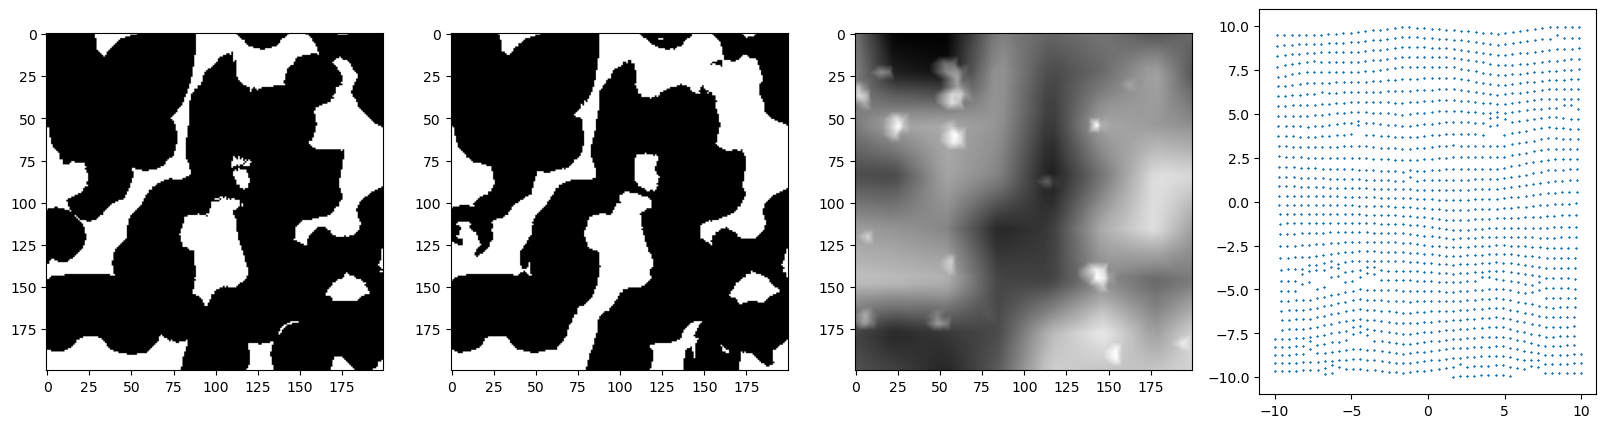

In [49]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(safety_target, cmap='gray')
axs[1].imshow(safety_coarse_target, cmap='gray')
axs[2].imshow(dem_coarse_target, cmap='gray')
axs[3].scatter(pcd_target[:, 0], pcd_target[:, 1], s=0.5, marker='x')


In [9]:
rays_c = rays_in_c(64)

theta = 30.0 * np.pi / 180.0
e1_c = np.array([-1.0, 0.0, 0.0])
e3_c = np.array([0.0, -np.sin(theta), -np.cos(theta)])
e2_c = np.cross(e3_c, e1_c)
R_C2W = np.vstack((e1_c, e2_c, e3_c)).T

rays_w = R_C2W @ rays_c.T
rays_w = rays_w.T

n = rays_w.shape[0]
alt = 300.0
src = np.array([0.0, alt * np.sin(theta), alt * np.cos(theta)] * n).reshape(n, 3)

pcd, idr, _ = dtm.ray.intersects_location(src, rays_w, multiple_hits=False)

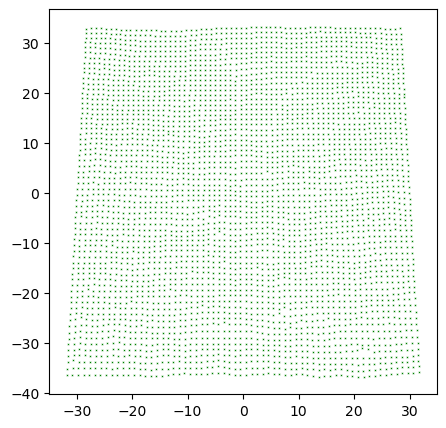

In [11]:
plt.figure(figsize=(5, 5))
plt.scatter(pcd[:, 0], pcd[:, 1], c='g', s=0.1, marker='x')

In [23]:
# target region
x_min, x_max = -10, 10
y_min, y_max = -10, 10
mask = (xx > x_min) & (xx < x_max) & (yy > y_min) & (yy < y_max)
print(mask.shape)

(1024, 1024)


In [28]:
from scipy.interpolate import LinearNDInterpolator
interp = LinearNDInterpolator(pcd[:, :2], pcd[:, 2], fill_value=0.0)
dem_coarse = interp(xx, yy)
print(dem_coarse.shape)

(1024, 1024)


In [37]:
dl = 3.0
dp = 0.3
rmpp = 0.1

_, _, _, _, psafe_coarse, _ = hd.alhat(
    dem_coarse, 
    rmpp=rmpp, 
    lander_type='square', 
    dl=dl, 
    dp=dp,
    scrit=10*np.pi/180,
    rcrit=0.3,
    sigma=0.05/3)


In [38]:
mask.shape

(1024, 1024)

In [41]:
psafe_target = psafe[mask]
psafe_target_coarse = psafe_coarse[mask]

shape = (int((x_max - x_min) / res), int((y_max - y_min) / res))
psafe_target = psafe_target.reshape(shape)
psafe_target_coarse = psafe_target_coarse.reshape(shape)

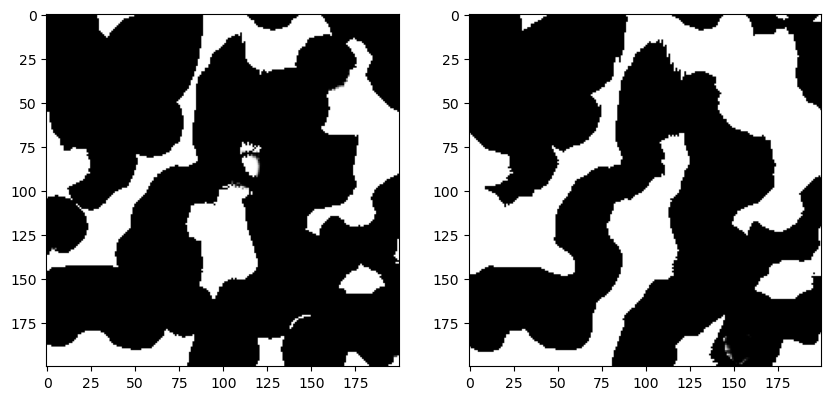

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(psafe_target, cmap='gray')
axs[1].imshow(psafe_target_coarse, cmap='gray')


In [238]:
import numpy as np
import trimesh
from PIL import Image

def generate_simulated_image(mesh, camera_position, camera_fov, image_size):
    """
    Generate a simulated image using a pinhole camera model in Trimesh.

    :param mesh: Trimesh object of the mesh
    :param camera_position: 3D position of the camera (x, y, z)
    :param camera_fov: Field of view of the camera in degrees
    :param image_size: Tuple (width, height) for the output image size
    :return: PIL image of the simulated view
    """
    # Set the field of view and aspect ratio
    fov = np.deg2rad(camera_fov)
    aspect_ratio = image_size[0] / image_size[1]

    # Calculate focal length based on FOV
    focal_length = (image_size[0] / 2) / np.tan(fov / 2)

    # Create a camera and set its properties
    camera = trimesh.scene.Camera(resolution=image_size, focal=(focal_length, focal_length * aspect_ratio))

    # Create a scene with the mesh
    scene = trimesh.Scene(mesh)

    # Create a transformation matrix for the camera
    camera_transform = np.eye(4)
    camera_transform[:3, 3] = camera_position

    # Set the camera's transform
    scene.set_camera(camera=camera, transform=camera_transform)

    # Render the scene to an image
    image_data = scene.save_image(visible=True)

    # Convert to PIL image
    image = Image.open(trimesh.util.wrap_as_stream(image_data))

    return image

# Example usage

camera_pose = [0, 0, 10]  # Replace with your camera position
camera_fov = 60  # Camera field of view in degrees
image_size = (800, 600)  # Image resolution

# Generate the image
simulated_image = generate_simulated_image(dtm, camera_pose, camera_fov, image_size)
simulated_image.show()


TypeError: set_camera() got an unexpected keyword argument 'camera'